In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

In [2]:
#leggo i dataframe dal disco
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = 'drive/MyDrive/Colab Notebooks/PHP4/Remaining_Life_Estimation'

Mounted at /content/drive


In [3]:
### LOAD TRAIN ###
train_df = pd.read_csv(DATA_PATH + '/PM_train.txt', sep=" ", header=None)
train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN


In [4]:
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(train_df.id.unique()))
train_df = train_df.sort_values(['id','cycle'])
print(train_df.shape)
train_df.head(3)

#id: 100
(20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442


medium working time: 206.31
max working time: 362
min working time: 128


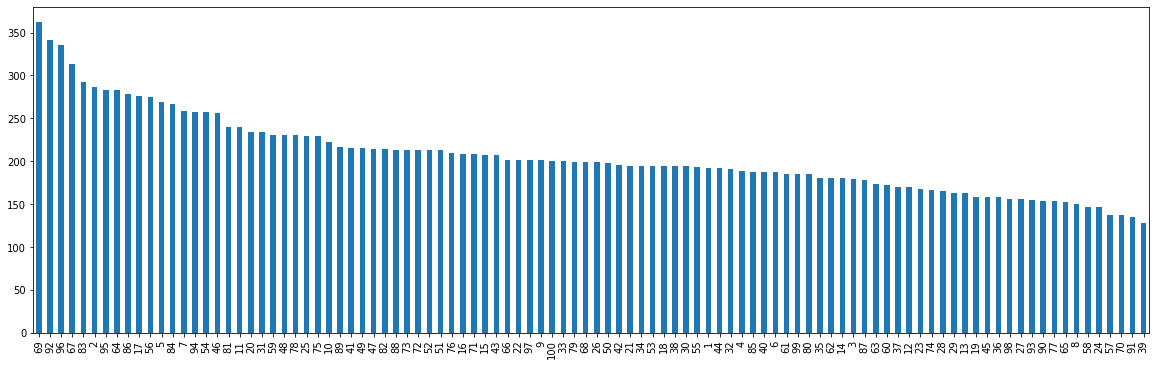

In [5]:
### PLOT TRAIN FREQ ###
plt.figure(figsize=(20,6))
train_df.id.value_counts().plot.bar()
print("medium working time:", train_df.id.value_counts().mean())
print("max working time:", train_df.id.value_counts().max())
print("min working time:", train_df.id.value_counts().min())

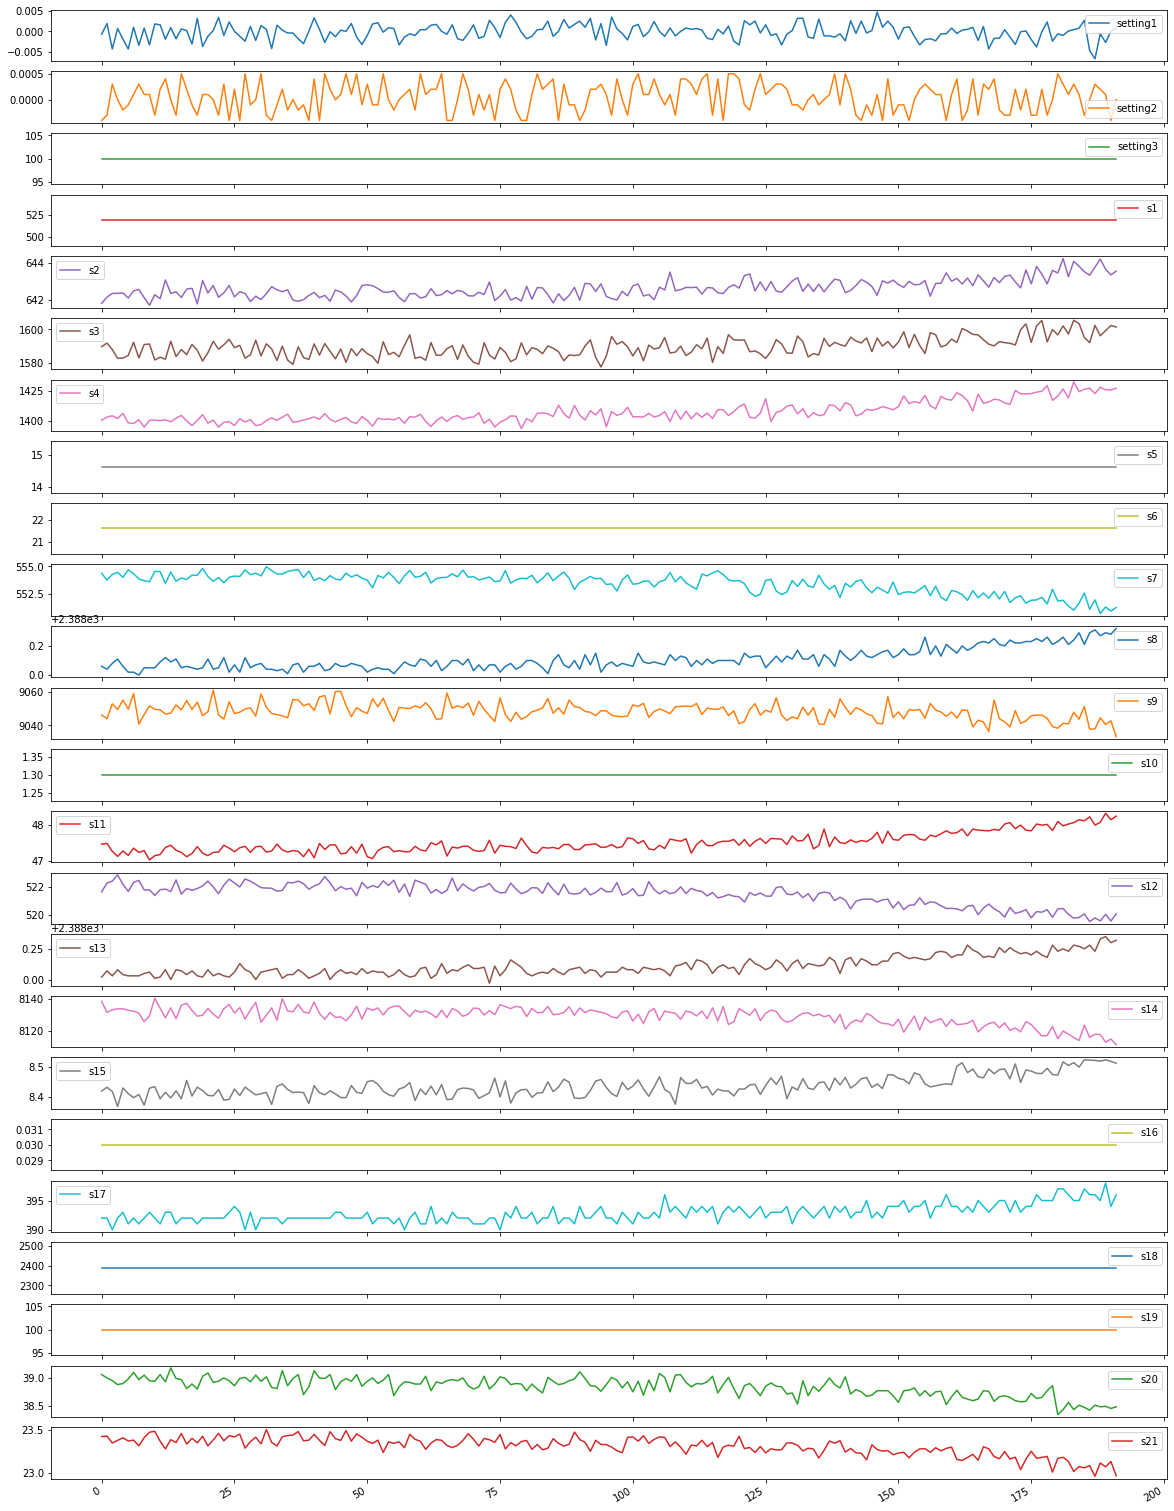

In [6]:
### plotting sensor data for engine ID ###
engine_id = train_df[train_df['id'] == 1]

ax1 = engine_id[train_df.columns[2:]].plot(subplots=True, sharex=True, figsize=(20,30))

In [7]:
### LOAD TEST ###
test_df = pd.read_csv(DATA_PATH + '/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(test_df.id.unique()))
print(test_df.shape)
test_df.head(3)

#id: 100
(13096, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.2,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.5,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.5,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


In [8]:
### LOAD GROUND TRUTH ###
truth_df = pd.read_csv(DATA_PATH + '/PM_truth.txt', sep=" ", header=None)
truth_df

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN
...,...,...
95,137,NaN
96,82,NaN
97,59,NaN
98,117,NaN


In [9]:
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.columns = ['more']
truth_df = truth_df.set_index(truth_df.index + 1)

print(truth_df.shape)
truth_df.head(3)

(100, 1)


,more
1,112
2,98
3,69


In [10]:
train_df.groupby(['id'])['cycle'].transform(max)-train_df['cycle']

0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: cycle, Length: 20631, dtype: int64

In [11]:
### CALCULATE RUL TRAIN ###
train_df['RUL']=train_df.groupby(['id'])['cycle'].transform(max)-train_df['cycle']
train_df[0:10]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,186
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,185
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,184
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,183
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,182


In [12]:
### ADD NEW LABEL TRAIN ###
w1 = 45
w0 = 15
train_df['label0'] = np.where(train_df['RUL'] > w1, 1, 0 )
train_df['label1'] = np.where((train_df['RUL'] > w0) & (train_df['RUL'] <= w1), 1, 0 )
train_df['label2'] = np.where(train_df['RUL'] <= w0, 1, 0 )
train_df[0:10]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label0,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,1,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,1,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,1,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,1,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,1,0,0
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,186,1,0,0
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,185,1,0,0
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,184,1,0,0
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,183,1,0,0
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,182,1,0,0


In [21]:
train_df[train_df['label2'] == 1].count()

id          1600
cycle       1600
setting1    1600
setting2    1600
setting3    1600
s1          1600
s2          1600
s3          1600
s4          1600
s5          1600
s6          1600
s7          1600
s8          1600
s9          1600
s10         1600
s11         1600
s12         1600
s13         1600
s14         1600
s15         1600
s16         1600
s17         1600
s18         1600
s19         1600
s20         1600
s21         1600
RUL         1600
label0      1600
label1      1600
label2      1600
dtype: int64

In [ ]:
### SCALE TRAIN DATA ###
from sklearn.preprocessing import StandardScaler

cols = []
for col in train_df.columns:
    if col[0] == 's':
        cols.append(col)

scaler = StandardScaler()
train_df[cols]=scaler.fit_transform(train_df[cols])
train_df = train_df.dropna(axis=1)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label0,label1,label2
0,1,1,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,-1.0,0.141683,1.121141,-0.516338,-0.862813,0.0,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-1.0,-0.781710,0.0,0.0,1.348493,1.194427,191,1,0,0
1,1,2,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,-1.0,0.141683,0.431930,-0.798093,-0.958818,0.0,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-1.0,-0.781710,0.0,0.0,1.016528,1.236922,190,1,0,0
2,1,3,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,-1.0,0.141683,1.008155,-0.234584,-0.557139,0.0,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-1.0,-2.073094,0.0,0.0,0.739891,0.503423,189,1,0,0
3,1,4,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,-1.0,0.141683,1.222827,0.188048,-0.713826,0.0,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-1.0,-0.781710,0.0,0.0,0.352598,0.777792,188,1,0,0
4,1,5,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,-1.0,0.141683,0.714393,-0.516338,-0.457059,0.0,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-1.0,-0.136018,0.0,0.0,0.463253,1.059552,187,1,0,0


In [ ]:
truth_df['max'] = test_df.groupby('id')['cycle'].max() + truth_df['more']
truth_df

,more,max
1,112,143
2,98,147
3,69,195
4,82,188
5,91,189
...,...,...
96,137,234
97,82,216
98,59,180
99,117,214


In [ ]:
### CALCULATE RUL TEST ###
test_df['RUL'] = [truth_df['max'][i] for i in test_df.id] - test_df['cycle']
test_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [ ]:
### ADD NEW LABEL TEST ###
test_df['label0'] = np.where(test_df['RUL'] > w1, 1, 0 )
test_df['label1'] = np.where((test_df['RUL'] > w0) & (test_df['RUL'] <= w1), 1, 0 )
test_df['label2'] = np.where(test_df['RUL'] <= w0, 1, 0 )
test_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label0,label1,label2
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,1,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,1,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,1,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,1,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24,0,1,0
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23,0,1,0
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22,0,1,0
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21,0,1,0


In [ ]:
### SCALE TEST DATA ###

test_df[cols]=scaler.transform(test_df[cols])
test_df = test_df.dropna(axis=1)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label0,label1,label2
0,1,1,1.055599,1.015677,0.0,0.0,0.678077,-0.853550,-1.191480,-1.0,0.141683,0.601408,-0.798093,-0.682579,0.0,-1.277396,0.415614,-0.919841,-0.954235,-0.985107,-1.0,-0.781710,0.0,0.0,0.241943,0.774097,142,1,0,0
1,1,2,-1.230366,-1.031720,0.0,0.0,-1.941707,-0.338137,-1.501467,-1.0,0.141683,1.674769,-1.220725,-0.490117,0.0,-0.154141,1.012195,-0.502695,-0.216648,-1.649034,-1.0,-0.136018,0.0,0.0,1.127183,0.941305,141,1,0,0
2,1,3,0.141213,0.333211,0.0,0.0,-0.441831,-0.584426,-0.843717,-1.0,0.141683,0.838677,-0.657216,-0.375093,0.0,-0.154141,0.754581,-0.919841,-0.715712,0.052112,-1.0,-0.136018,0.0,0.0,1.459148,1.172256,140,1,0,0
3,1,4,1.924266,-0.008022,0.0,0.0,-0.481827,-1.044384,-0.279297,-1.0,0.141683,0.793483,-0.938970,-0.903570,0.0,-0.977861,-0.045381,-0.641744,-0.568929,-1.345067,-1.0,-1.427402,0.0,0.0,1.016528,0.775945,139,1,0,0
4,1,5,0.644125,-0.008022,0.0,0.0,-0.341839,-0.543650,-0.779276,-1.0,0.141683,0.895170,-1.220725,-0.937081,0.0,-0.865536,0.998637,-0.919841,-0.745069,-1.041101,-1.0,-2.073094,0.0,0.0,0.961200,1.138999,138,1,0,0


In [ ]:
train_df_y = train_df[['id','cycle','label0','label1','label2']]
test_df_y = test_df[['id','cycle','label0','label1','label2']]
train_df.drop(['RUL','label0','label1','label2'],axis=1,inplace=True)
test_df.drop(['RUL','label0','label1','label2'],axis=1,inplace=True)

In [ ]:
#salvo i dataframe su disco
train_df.to_pickle(DATA_PATH + '/train_df.pkl')
test_df.to_pickle(DATA_PATH + '/test_df.pkl')
train_df_y.to_pickle(DATA_PATH + '/train_df_y.pkl')
test_df_y.to_pickle(DATA_PATH + '/test_df_y.pkl')